In [21]:
# dirvae.py
# PyTorch implementation of DirVAE (inverse-Gamma CDF approximation) from:
# "Dirichlet Variational Autoencoder" (Joo et al., ICLR 2019)
# Uses Bernoulli decoder for binary images (e.g. MNIST).
#
# Usage: instantiate DirVAE(input_dim, hidden_dim, latent_dim), use loss_fn below,
# then train normally.
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Uniform
EPS = 1e-8
class MLPEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dims, latent_dim,bottle):
        super().__init__()
        self.bottle=bottle
        layers = []
        last = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(last, h))
            layers.append(nn.ReLU(inplace=True))
            last = h
        self.net = nn.Sequential(*layers)
        # output positive concentration parameters \hat{alpha} for each latent dim
        self.alpha_layer = nn.Linear(last, latent_dim)
        self.mu_layer = nn.Linear(last, latent_dim)
        self.logvar_layer = nn.Linear(last, latent_dim)
    def forward(self, x):
        h = self.net(x)
        # softplus to ensure positive alpha_hat; add small bias to avoid zero
        if self.bottle=="dir":
          alpha_hat = F.softplus(self.alpha_layer(h))
          alpha_hat = alpha_hat.clamp(min=1e-3, max=50)
          return alpha_hat
        elif self.bottle=="gaus":
          mu = self.mu_layer(h)
          logvar = self.logvar_layer(h)
          return mu, logvar


class BernoulliDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dims, output_dim):
        super().__init__()
        layers = []
        last = latent_dim
        for h in hidden_dims:
            layers.append(nn.Linear(last, h))
            layers.append(nn.ReLU(inplace=True))
            last = h
        layers.append(nn.Linear(last, output_dim))
        self.net = nn.Sequential(*layers)
    def forward(self, z):
        logits = self.net(z)
        # return logits (use BCEWithLogitsLoss)
        return logits


class GaussianVAE(nn.Module):
    def __init__(self, input_dim, enc_hidden_dims, dec_hidden_dims, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = MLPEncoder(input_dim, enc_hidden_dims, latent_dim,"gaus")
        self.decoder = BernoulliDecoder(latent_dim, dec_hidden_dims, input_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        logits = self.decoder(z)
        return logits, mu, logvar, z

class DirVAE(nn.Module):
    def __init__(self, input_dim, enc_hidden_dims, dec_hidden_dims, latent_dim,
                 prior_alpha=None, beta=1.0):
        """
        input_dim: flattened input size (e.g. 28*28)
        enc_hidden_dims: list of encoder hidden sizes
        dec_hidden_dims: list of decoder hidden sizes
        latent_dim: K
        prior_alpha: vector or scalar for Dirichlet prior concentration alpha (if scalar, replicate)
        beta: rate parameter for Gammas (paper uses beta=1)
        """
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = MLPEncoder(input_dim, enc_hidden_dims, latent_dim,"dir")
        self.decoder = BernoulliDecoder(latent_dim, dec_hidden_dims, input_dim)
        if prior_alpha is None:
            # default weak symmetric prior; user can override
            prior_alpha = torch.ones(latent_dim) * 0.98
        elif torch.is_tensor(prior_alpha):
            if prior_alpha.numel() == 1:
                prior_alpha = prior_alpha.repeat(latent_dim)
        else:
            # numeric scalar
            prior_alpha = torch.tensor(float(prior_alpha)).repeat(latent_dim)
        self.register_buffer('prior_alpha', prior_alpha.float())
        self.beta = float(beta)
    def inverse_gamma_cdf_approx(self, u, alpha):
        """
        Approximate inverse CDF for X ~ Gamma(alpha, beta) using:
        F^{-1}(u; alpha, beta) ≈ beta^{-1} * (u * alpha * Gamma(alpha))^{1/alpha}
        u: uniform samples in (0,1), shape (batch, K)
        alpha: shape (batch, K) or (K,)
        returns: approx gamma samples shape (batch, K)
        """
        # alpha * Gamma(alpha) = alpha * exp(lgamma(alpha))
        # note: torch.lgamma for log Gamma
        # shapes broadcast
        log_gamma = torch.lgamma(alpha)
        a_gamma = alpha * torch.exp(log_gamma)  # shape (batch, K)
        # clamp u to (eps, 1)
        u = u.clamp(min=EPS, max=1.0 - 1e-12)
        base = u * a_gamma
        # to avoid negative/zero values due to numerical issues, clamp base
        base = base.clamp(min=EPS)
        # power 1/alpha
        samples = (base) ** (1.0 / alpha)
        # divide by beta (rate)
        samples = samples / (self.beta + 0.0)
        return samples
    def sample_dirichlet_from_alpha(self, alpha_hat):
        """
        Given alpha_hat (batch, K), produce reparam samples z on simplex:
          1) draw u ~ Uniform(0,1) per component
          2) approximate gamma sample via inverse Gamma CDF approx
          3) normalize v -> z = v / sum_k v_k
        Returns z (batch, K), v (batch, K), u (for reproducibility)
        """
        batch = alpha_hat.shape[0]
        # Uniform draws per component
        u = torch.rand_like(alpha_hat)  # Uniform(0,1)
        v = self.inverse_gamma_cdf_approx(u, alpha_hat)
        # Normalize to get Dirichlet sample
        denom = v.sum(dim=1, keepdim=True).clamp(min=EPS)
        z = v / denom
        return z, v, u
    def forward(self, x):
        """
        x: flattened input (batch, input_dim) with values in [0,1] for Bernoulli decoding
        returns: reconstruction logits, z, alpha_hat, v
        """
        alpha_hat= self.encoder(x)  # (batch, K)
        z, v, u = self.sample_dirichlet_from_alpha(alpha_hat)  # z in simplex
        logits = self.decoder(z)  # (batch, input_dim)
        return logits, z, alpha_hat, v
def multi_gamma_kl(alpha_hat, prior_alpha, reduction='batchmean'):
    """
    KL between MultiGamma(alpha_hat, beta=1) and MultiGamma(prior_alpha, beta=1)
    Per paper (Equation 3):
      KL(Q||P) = sum_k [ log Gamma(alpha_k) - log Gamma(alpha_hat_k) + (alpha_hat_k - alpha_k) * psi(alpha_hat_k) ]
    alpha_hat: (batch, K)
    prior_alpha: (K,) or (batch, K)
    reduction: 'batchmean', 'sum', 'none'
    Returns scalar KL (averaged over batch if batchmean)
    """
    # broadcast prior_alpha to batch if necessary
    if prior_alpha.dim() == 1:
        prior = prior_alpha.unsqueeze(0).expand_as(alpha_hat)
    else:
        prior = prior_alpha
    term1 = torch.lgamma(prior) - torch.lgamma(alpha_hat)
    term2 = (alpha_hat - prior) * torch.digamma(alpha_hat)
    kl_comp = term1 + term2
    kl = kl_comp.sum(dim=1)  # per example sum over K
    if reduction == 'batchmean':
        return kl.mean()
    elif reduction == 'sum':
        return kl.sum()
    else:
        return kl  # per example
def dirvae_elbo_loss(model, x, reduction='mean'):
    """
    Compute negative ELBO (loss to minimize) for Bernoulli decoder.
    x: (batch, input_dim) values in {0,1} or [0,1]
    returns loss (scalar), recon_loss (scalar), kl (scalar)
    """
    logits, z, alpha_hat, v = model(x)
    # Reconstruction: bernoulli likelihood -> BCEWithLogits
    bce = F.binary_cross_entropy_with_logits(logits, x, reduction='none')
    recon_per_sample = bce.sum(dim=1)  # per example reconstruction negative log-likelihood
    if reduction == 'mean':
        recon_loss = recon_per_sample.mean()
    else:
        recon_loss = recon_per_sample.sum()
    # KL between MultiGamma post (alpha_hat) and prior MultiGamma (prior_alpha)
    kl = multi_gamma_kl(alpha_hat, model.prior_alpha, reduction='batchmean')
    # ELBO = E_q[log p(x|z)] - KL -> loss = -ELBO = recon_loss + KL
    loss = recon_loss + kl
    return loss, recon_loss, kl


def gaussian_vae_elbo_loss(model, x, reduction='mean'):
    """
    Negative ELBO for Gaussian VAE with Bernoulli likelihood.
    """
    logits, mu, logvar, z = model(x)

    # Reconstruction loss
    bce = F.binary_cross_entropy_with_logits(logits, x, reduction='none')
    recon_per_sample = bce.sum(dim=1)
    if reduction == 'mean':
        recon_loss = recon_per_sample.mean()
    else:
        recon_loss = recon_per_sample.sum()

    # KL divergence between q(z|x) and N(0, I)
    kl_per_sample = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    if reduction == 'mean':
        kl = kl_per_sample.mean()
    else:
        kl = kl_per_sample.sum()

    loss = recon_loss + kl
    return loss, recon_loss, kl



# ----------------------------
# Example training loop skeleton
# ----------------------------
if __name__ == "__main__":
    # Quick usage example for MNIST-like data (flattened, binary)
    import torchvision
    import torchvision.transforms as T
    from torch.utils.data import DataLoader
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


    input_dim = 28 * 28
    latent_dim = 50
    epochs=15
    batch_size=100
    learning_rate=5e-4

    # Simple binarization transform
    transform = T.Compose([T.ToTensor(), lambda t: t.view(-1)])
    trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True,transform=transform)
    loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)



    model_DIR = DirVAE(input_dim=input_dim,
                   enc_hidden_dims=[500,500],
                   dec_hidden_dims=[500],
                   latent_dim=latent_dim,
                   prior_alpha=0.98).to(device)
    optimizer_DIR = torch.optim.Adam(model_DIR.parameters(), lr=learning_rate)
    for epoch in range(1, epochs):
        model_DIR.train()
        tot_loss = 0.0
        tot_recon = 0.0
        tot_kl = 0.0
        samlet=0

        for xb, _ in loader:
            xb = xb.to(device)
            optimizer_DIR.zero_grad()
            loss, recon, kl = dirvae_elbo_loss(model_DIR, xb, reduction='mean')
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model_DIR.parameters(), 5.0)
            optimizer_DIR.step()
            tot_loss += loss.item() * xb.size(0)
            tot_recon += recon.item() * xb.size(0)
            tot_kl += kl.item() * xb.size(0)

        n = len(loader.dataset)
        print(f"Epoch {epoch:02d} DIR Loss {tot_loss/n:.4f} Recon {tot_recon/n:.4f} KL {tot_kl/n:.4f}")


    model_GAU = GaussianVAE(input_dim, [500, 500], [500], latent_dim).to(device)
    optimizer_GAU = torch.optim.Adam(model_GAU.parameters(), lr=learning_rate)

    for epoch in range(1, epochs
                       ):
        model_GAU.train()
        tot_loss = tot_recon = tot_kl = 0.0
        for xb, _ in loader:
            xb = xb.to(device)
            optimizer_GAU.zero_grad()
            loss, recon, kl = gaussian_vae_elbo_loss(model_GAU, xb, reduction='mean')
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model_GAU.parameters(), 5.0)
            optimizer_GAU.step()
            tot_loss += loss.item() * xb.size(0)
            tot_recon += recon.item() * xb.size(0)
            tot_kl += kl.item() * xb.size(0)

        n = len(loader.dataset)
        print(f"Epoch {epoch:02d} GAUSS| Loss {tot_loss/n:.4f} | Recon {tot_recon/n:.4f} | KL {tot_kl/n:.4f}")


Epoch 01 DIR Loss 242.5551 Recon 242.4461 KL 0.1090
Epoch 02 DIR Loss 204.3832 Recon 203.0770 KL 1.3062
Epoch 03 DIR Loss 195.2192 Recon 192.1248 KL 3.0944
Epoch 04 DIR Loss 191.6494 Recon 188.4659 KL 3.1835
Epoch 05 DIR Loss 187.2142 Recon 182.9907 KL 4.2235
Epoch 06 DIR Loss 183.1405 Recon 178.3730 KL 4.7675
Epoch 07 DIR Loss 179.6758 Recon 174.3878 KL 5.2880
Epoch 08 DIR Loss 176.4474 Recon 170.6256 KL 5.8218
Epoch 09 DIR Loss 170.7420 Recon 163.3614 KL 7.3806
Epoch 10 DIR Loss 165.2902 Recon 156.7566 KL 8.5336
Epoch 11 DIR Loss 161.6798 Recon 152.6147 KL 9.0651
Epoch 12 DIR Loss 158.4063 Recon 148.6820 KL 9.7242
Epoch 13 DIR Loss 153.7866 Recon 142.9076 KL 10.8790
Epoch 14 DIR Loss 150.0802 Recon 138.6552 KL 11.4250
Epoch 01 GAUSS| Loss 175.9507 | Recon 161.0721 | KL 14.8786
Epoch 02 GAUSS| Loss 136.7917 | Recon 116.1213 | KL 20.6704
Epoch 03 GAUSS| Loss 124.9694 | Recon 102.1664 | KL 22.8030
Epoch 04 GAUSS| Loss 117.9601 | Recon 94.4571 | KL 23.5030
Epoch 05 GAUSS| Loss 113.9043 |

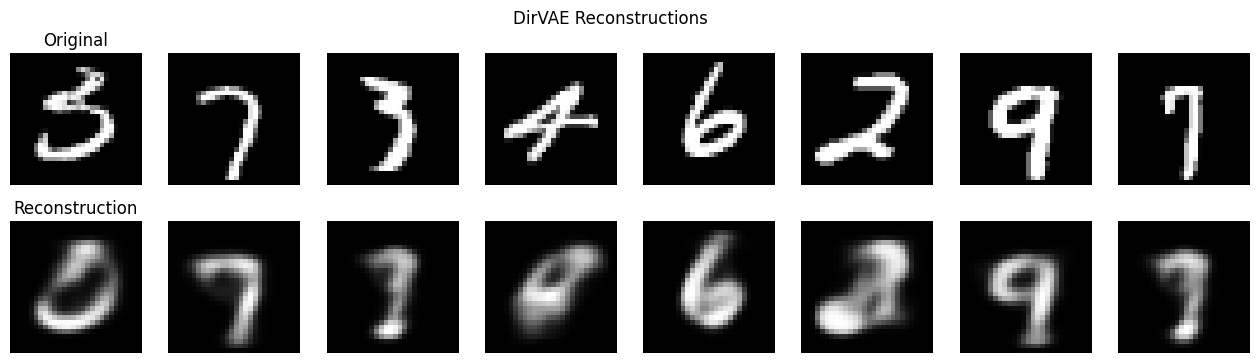

Computing t-SNE projection of DirVAE latent space...


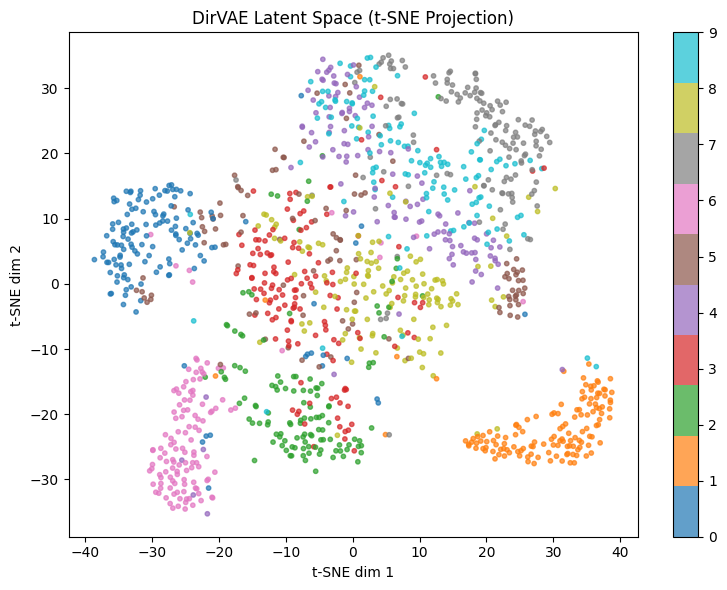

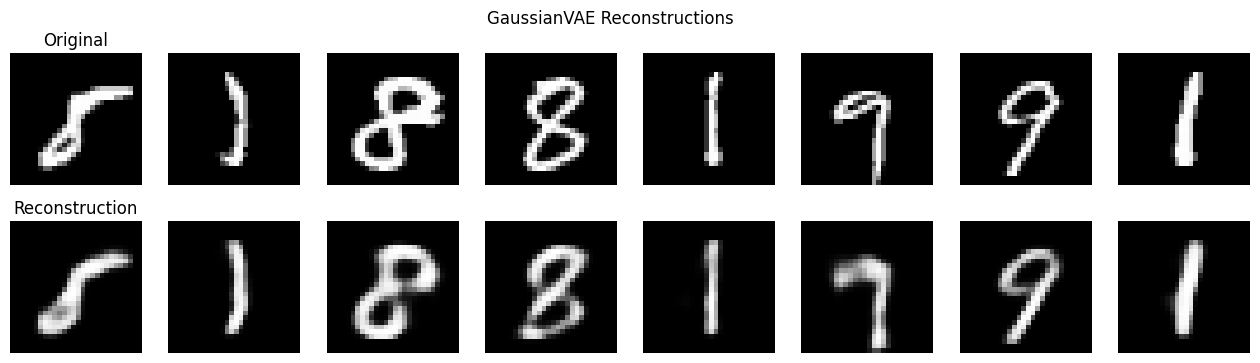

Computing t-SNE projection of GaussianVAE latent space...


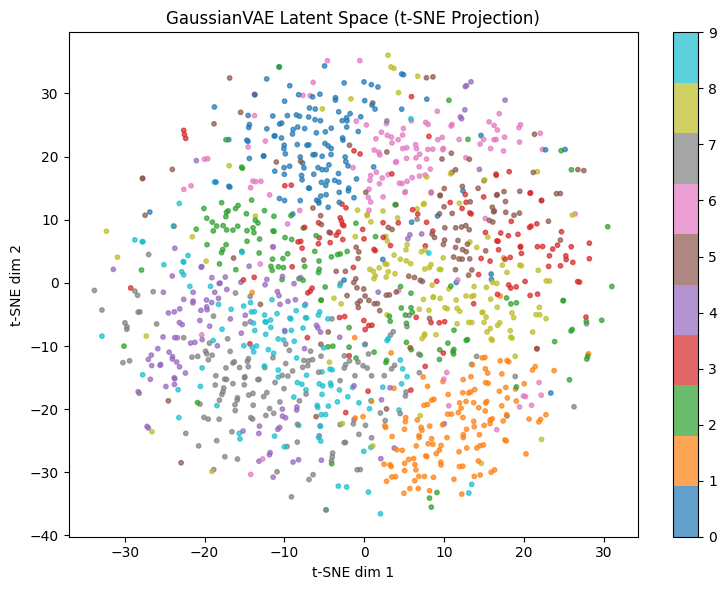

In [23]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch
import numpy as np

def visualize_model(model, loader, device, model_name="Model", n_samples=8, tsne_samples=1280):
    model.eval()

    # -----------------------------
    # Plot some reconstructions
    # -----------------------------
    xb, yb = next(iter(loader))
    xb = xb.to(device)
    with torch.no_grad():
        if isinstance(model, DirVAE):
            logits, z, _, _ = model(xb)
        else:  # GaussianVAE
            logits, mu, logvar, z = model(xb)
        recon = torch.sigmoid(logits)

    xb_np = xb.cpu().numpy()
    recon_np = recon.cpu().numpy()

    plt.figure(figsize=(2*n_samples, 4))
    for i in range(n_samples):
        # Original
        plt.subplot(2, n_samples, i + 1)
        plt.imshow(xb_np[i].reshape(28, 28), cmap="gray")
        plt.axis("off")
        if i == 0:
            plt.title("Original")

        # Reconstruction
        plt.subplot(2, n_samples, n_samples + i + 1)
        plt.imshow(recon_np[i].reshape(28, 28), cmap="gray")
        plt.axis("off")
        if i == 0:
            plt.title("Reconstruction")

    plt.suptitle(f"{model_name} Reconstructions")
    plt.show()

    # -----------------------------
    # Visualize latent space (t-SNE)
    # -----------------------------
    print(f"Computing t-SNE projection of {model_name} latent space...")

    z_all = []
    y_all = []

    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            if isinstance(model, DirVAE):
                _, z, _, _ = model(xb)
            else:  # GaussianVAE
                _, mu, logvar, z = model(xb)
            z_all.append(z.cpu())
            y_all.append(yb)
            if sum(len(a) for a in z_all) >= tsne_samples:
                break

    z_all = torch.cat(z_all, dim=0)[:tsne_samples].numpy()
    y_all = torch.cat(y_all, dim=0)[:tsne_samples].numpy()

    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    z_2d = tsne.fit_transform(z_all)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(z_2d[:, 0], z_2d[:, 1], c=y_all, cmap="tab10", s=10, alpha=0.7)
    plt.colorbar(scatter, ticks=range(10))
    plt.title(f"{model_name} Latent Space (t-SNE Projection)")
    plt.xlabel("t-SNE dim 1")
    plt.ylabel("t-SNE dim 2")
    plt.tight_layout()
    plt.show()


# -----------------------------
# Usage
# -----------------------------
visualize_model(model_DIR, loader, device, model_name="DirVAE")
visualize_model(model_GAU, loader, device, model_name="GaussianVAE")
